In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython
import scipy
import pandas as pd
import numpy as np
import anndata
import gseapy
import statannotations
from statannotations.Annotator import Annotator

sc.settings.figdir=os.path.expanduser('~/WbFigures/DevDE')
sc._settings.settings._vector_friendly = True
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42
})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import sys
import antipode
import antipode.antipode_model
import antipode.model_functions
import antipode.model_distributions
import antipode.model_modules
import antipode.train_utils
import antipode.plotting
import antipode.post

from antipode.post import uniqlist
plt.rc("axes.spines", top=False, right=False)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
MDE_KEY = "X_antipode_UMAP"
leaf_key = 'level_2'
anndata.settings.allow_write_nullable_strings = True

model_tag   = '1.9.1.8.5_Dev_final_600clusters'
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag
adata = sc.read_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))
antipode_model=antipode.antipode_model.ANTIPODE.load(model_path,adata=adata,prefix='p3_',device=device)
antipode_model.save_params_to_uns()
adata=antipode_model.adata_manager.adata
pstore = adata.uns['param_store']
adata.var = pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/gene_lists/var.csv',index_col=0)

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [3]:
antipode_model.to(device)
posterior_means = antipode_model.get_posterior_cluster_means(batch_size=128,device=device)

  0%|          | 0/14491 [00:00<?, ?it/s]/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d_codes = adata.obs[self.discov_key].cat.codes[idx].values
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  l_codes = adata.obs[leaf_level_col].cat.codes[idx].values
100%|██████████| 14491/14491 [16:55<00:00, 14.27it/s]


In [4]:
# pstore = adata.uns['param_store']
# discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
# keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
# cluster_labels = np.array(cluster_labels)[keep_clusters]
# zero_mask = zero_mask[:,keep_clusters,:]
# cluster_index = np.array([int(x) for x in cluster_labels])
# zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
# discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
# prop_locs = prop_locs[cluster_index,:]
# prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
# prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
# discov_labels=adata.obs[antipode_model.discov_key].cat.categories
# latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
# n_clusters=antipode_model.level_sizes[-1]

In [5]:
adata

AnnData object with n_obs × n_vars = 1854767 × 16738
    obs: 'Class', 'G2M_score', 'S_score', 'Subclass', 'batch_name', 'female', 'general_region', 'log10_n_counts', 'new_ccl', 'new_neighborhood_extended', 'phase', 'region', 'species', 'timepoint', 'general_region_species', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans', 'clean_cellname', 'dataset_name', 'doublet', 'full_cellname', 'individual', 'msregion', 'n_counts', 'n_genes', 'percent_ribo', 'singlet', 'species_dataset_name', 'anno_level_2', 'initial_class', 'ic_extended', 'abc_subclass_markercor', 'juv_subclass_markercor', 'linnarson_extended', 'lamanno_class', 'lamanno_subclass', 'lamanno_cluster', 'neighborhood', 'curated_class_label', 'new_neighborhood', 'ccl_extended', 'Neighborhood', 'Division', 'Initial_Class', 'Initial_Class_markers', 'Initial_Class_markers_level_2', 'clipped_psi_2', 'log_abs_sum_dynam', 'log10_n_genes'
    var: 'hi

In [6]:
# aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key,'level_2'],layer=layer_key,normalize=True)
# # aggr_sums=antipode.model_functions.group_aggr_anndata(adata,['level_2'],layer=layer_key,normalize=False,agg_func=np.sum)
# minam = aggr_means[0].flatten()[aggr_means[0].flatten()>0].min()
# log_real_means=np.log(aggr_means[0]+minam)
safe_log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(safe_log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]
log_real_means = safe_log_real_means

100%|██████████| 1140/1140 [02:29<00:00,  7.63it/s]


In [24]:
safe_log_real_means

array([[[-10.38471029, -11.16600655,  -8.52548774, ..., -11.28645313,
         -15.66748917, -15.66748917],
        [ -9.88525384, -10.1176163 ,  -9.52060075, ..., -10.80129844,
         -15.12171975, -14.50909972],
        [ -9.90491555, -10.27170285,  -8.87130237, ..., -10.83252254,
         -14.95709561, -14.98583766],
        ...,
        [-11.1713208 , -11.1230885 ,  -9.26235325, ..., -11.26083202,
         -15.0777224 , -12.39234473],
        [-10.58695244, -10.52161682,  -9.15950457, ..., -11.31357812,
         -14.80436222, -14.00712533],
        [-10.18635994, -10.89932726,  -9.11424964, ..., -11.12424008,
         -14.99188172, -14.99188172]],

       [[-10.42217529, -11.46930457, -11.216754  , ..., -11.19647772,
         -15.95891967, -12.22192719],
        [ -9.63501304, -10.608715  , -10.82070748, ..., -10.52804476,
         -14.0235431 , -14.26439074],
        [-10.19765408, -11.3345393 , -10.83641137, ..., -10.70439404,
         -15.41039585, -15.1339648 ],
        ...,


In [7]:
def prop_zeros(x,axis=-1):
    return(np.mean(x>0.,axis=axis))
aggr_zeros=antipode.model_functions.group_aggr_anndata(adata,[discov_key,leaf_key],layer=layer_key,agg_func=prop_zeros,normalize=True)

100%|██████████| 1140/1140 [03:59<00:00,  4.76it/s]


In [8]:
pstore = adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy',cluster_count_threshold=50)
keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
cluster_labels = np.array(cluster_labels)[keep_clusters]
zero_mask = zero_mask[:,keep_clusters,:]
cluster_index = np.array([int(x) for x in cluster_labels])
zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_locs = prop_locs[cluster_index,:]
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [9]:
centered_discov_cluster_params=discov_cluster_params-discov_cluster_params.mean(0)
centered_aggr_means=log_real_means-log_real_means.mean(0)

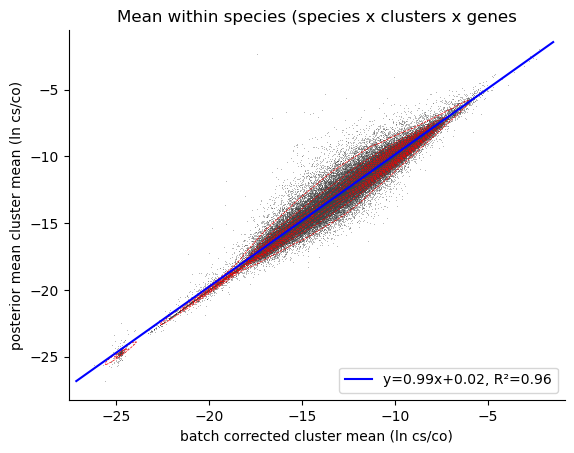

In [10]:
minpm = posterior_means.flatten()[posterior_means.flatten()>0].min()
x=discov_cluster_params.flatten()
y=np.log(posterior_means.flatten()+minpm)
mask = ~np.isnan(x) #& (y >-20) & (x >-20)
x=x[mask]
y=y[mask]

randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('batch corrected cluster mean (ln cs/co)')
plt.ylabel('posterior mean cluster mean (ln cs/co)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

filename = os.path.join(sc.settings.figdir, 'param_posterior_regression.png')
plt.savefig(filename, format='png')
plt.show()

In [27]:
safe_posterior_means = np.clip(np.log(posterior_means),a_min=np.nanmin(safe_log_real_means,1)[:,np.newaxis,:],a_max=0.)

safe_discov_cluster_params = np.clip(discov_cluster_params,a_min=np.nanmin(safe_log_real_means,1)[:,np.newaxis,:],a_max=0.)

/scratch/fast/2038308/ipykernel_2085424/3708211561.py:1: RuntimeWarning: divide by zero encountered in log
  safe_posterior_means = np.clip(np.log(posterior_means),a_min=np.nanmin(safe_log_real_means,1)[:,np.newaxis,:],a_max=0.)


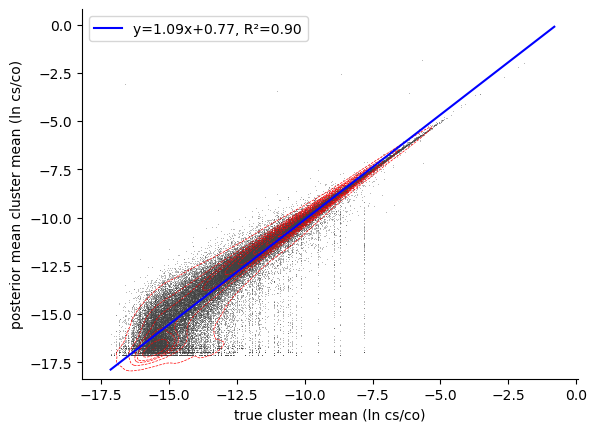

In [31]:
x=log_real_means.flatten()
y=safe_posterior_means.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('true cluster mean (ln cs/co)')
plt.ylabel('posterior mean cluster mean (ln cs/co)')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
# Add legend
plt.legend()

filename = os.path.join(sc.settings.figdir, 'real_cluster_regression.png')
plt.savefig(filename, format='png')
plt.show()

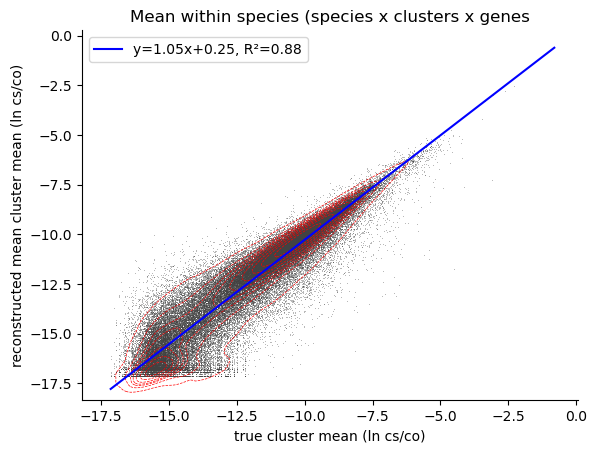

In [32]:
x=log_real_means.flatten()
y=safe_discov_cluster_params.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('true cluster mean (ln cs/co)')
plt.ylabel('reconstructed mean cluster mean (ln cs/co)')



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

filename = os.path.join(sc.settings.figdir, 'real_reconst_regression.png')
plt.savefig(filename, format='png')
plt.show()

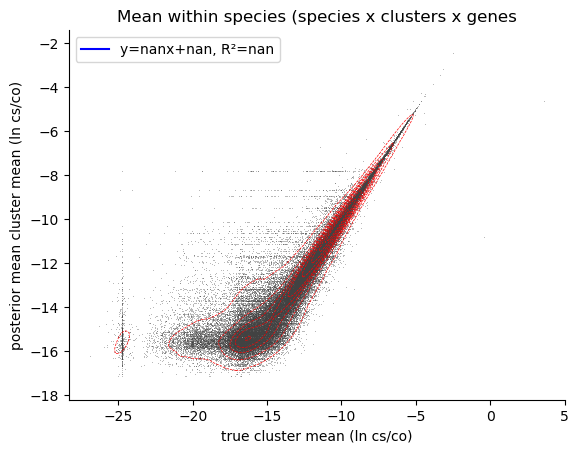

In [33]:
y=log_real_means.flatten()
# x=discov_cluster_params.flatten()
x=np.log(posterior_means.flatten()+minpm)
mask = ~np.isnan(x)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]

randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('true cluster mean (ln cs/co)')
plt.ylabel('posterior mean cluster mean (ln cs/co)')



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

# filename = os.path.join(sc.settings.figdir, 'real_cluster_regression.png')
# plt.savefig(filename, format='png')
plt.show()

/scratch/fast/2038308/ipykernel_2085424/1120137747.py:12: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)


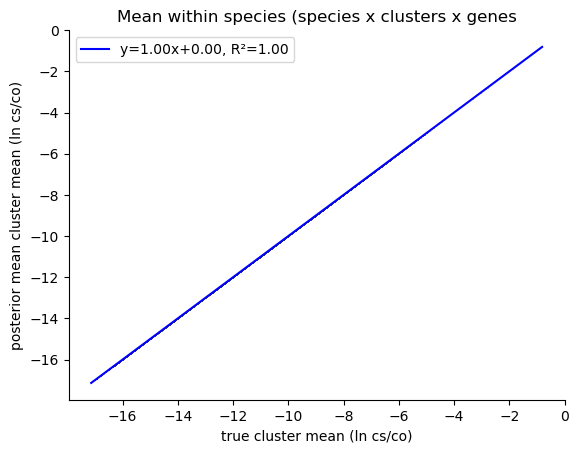

In [34]:
y=log_real_means.flatten()
x=discov_cluster_params.flatten()
z = y-x
x = x + z
mask = ~np.isnan(x)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]

randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('true cluster mean (ln cs/co)')
plt.ylabel('posterior mean cluster mean (ln cs/co)')



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

# filename = os.path.join(sc.settings.figdir, 'real_cluster_regression.png')
# plt.savefig(filename, format='png')
plt.show()

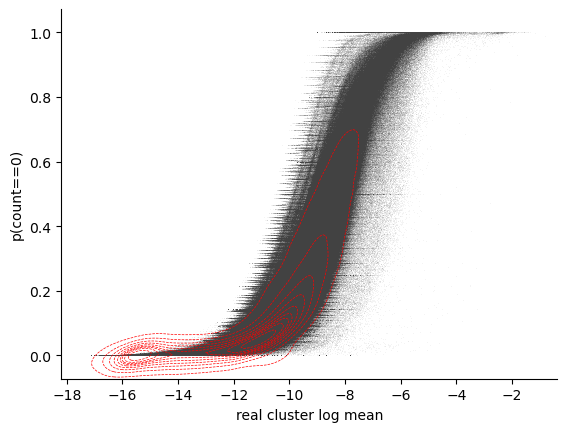

In [35]:
seaborn.scatterplot(x=log_real_means.flatten(),y=aggr_zeros[0].flatten(),s=0.1,alpha=0.3,color='black')
seaborn.kdeplot(x=log_real_means.flatten()[randinds], y=aggr_zeros[0].flatten()[randinds], linestyles='--', color='red', linewidths=0.5)

plt.xlabel('real cluster log mean')
plt.ylabel('p(count==0)')
plt.savefig(os.path.join(sc.settings.figdir, 'real_prob_zero.png'), format='png')


In [36]:
y.min()

np.float64(-17.137166147114996)

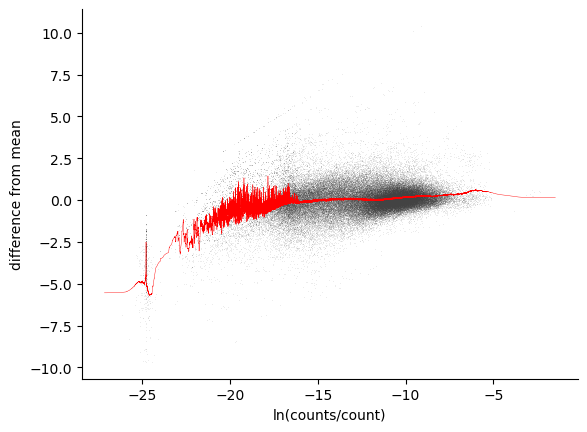

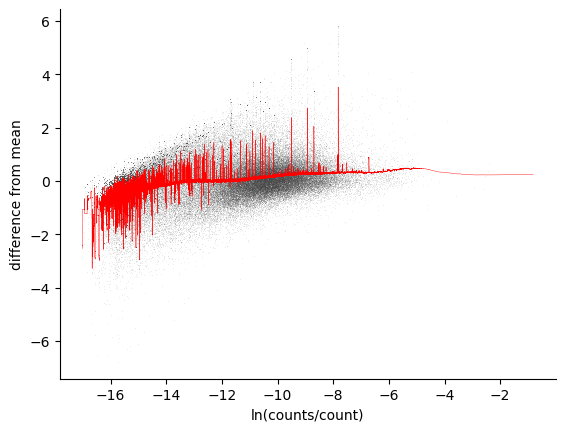

In [37]:
window_size = 2001
x = discov_cluster_params.flatten()
y = (discov_cluster_params-discov_cluster_params.mean(0)).flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.1,alpha=0.5,color='black')
# seaborn.kdeplot(x=x[randinds], y=y[randinds], linestyles='--', color='red', linewidths=0.5)
ma_x,ma_y=antipode.plotting.moving_average_values(x,y,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.3, label=f'Moving Average ({window_size} points)')

plt.xlabel('ln(counts/count)')
plt.ylabel('difference from mean')
plt.savefig(os.path.join(sc.settings.figdir, 'mean_vs_md.png'), format='png')
plt.show()

x = log_real_means.flatten()
y = (log_real_means-log_real_means.mean(0)).flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.1,alpha=0.5,color='black')
# seaborn.kdeplot(x=x[randinds], y=y[randinds], linestyles='--', color='red', linewidths=0.5)
ma_x,ma_y=antipode.plotting.moving_average_values(x,y,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.3, label=f'Moving Average ({window_size} points)')

plt.xlabel('ln(counts/count)')
plt.ylabel('difference from mean')
plt.savefig(os.path.join(sc.settings.figdir, 'real_mean_vs_md.png'), format='png')
plt.show()


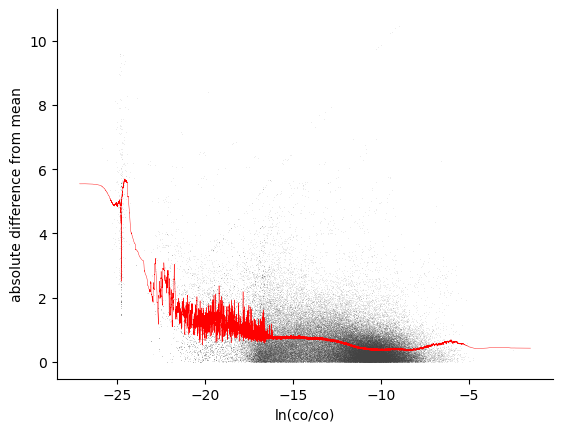

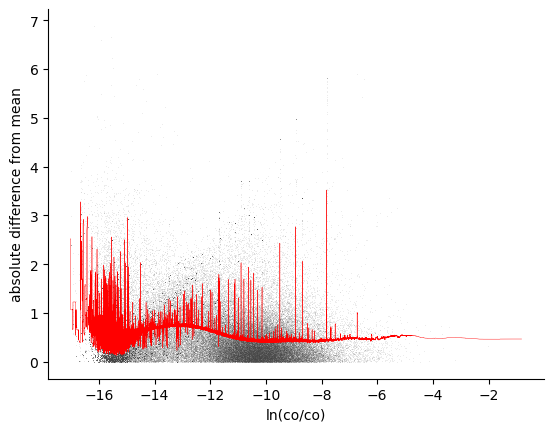

In [38]:
window_size = 2001
x = discov_cluster_params.flatten()
y = np.absolute(discov_cluster_params-discov_cluster_params.mean(0)).flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.1,alpha=0.5,color='black')
# seaborn.kdeplot(x=x[randinds], y=y[randinds], linestyles='--', color='red', linewidths=0.5)
ma_x,ma_y=antipode.plotting.moving_average_values(x,y,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.3, label=f'Moving Average ({window_size} points)')

plt.xlabel('ln(co/co)')
plt.ylabel('absolute difference from mean')
plt.savefig(os.path.join(sc.settings.figdir, 'reconst_mean_vs_mad.png'), format='png')
plt.show()

x = log_real_means.flatten()
y = np.absolute(log_real_means-log_real_means.mean(0)).flatten()
mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.1,alpha=0.5,color='black')
# seaborn.kdeplot(x=x[randinds], y=y[randinds], linestyles='--', color='red', linewidths=0.5)
ma_x,ma_y=antipode.plotting.moving_average_values(x,y,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.3, label=f'Moving Average ({window_size} points)')

plt.xlabel('ln(co/co)')
plt.ylabel('absolute difference from mean')
plt.savefig(os.path.join(sc.settings.figdir, 'real_mean_vs_mad.png'), format='png')
plt.show()


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


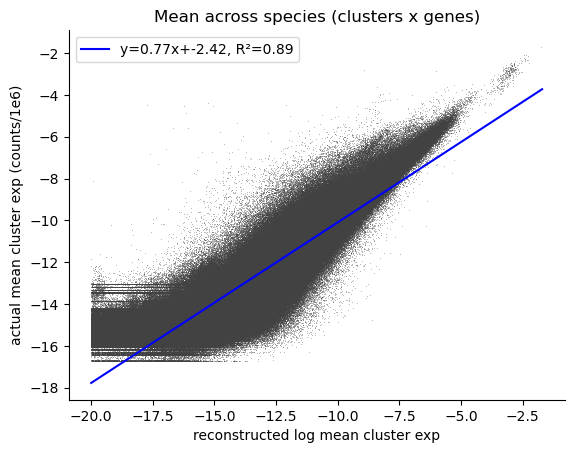

In [39]:
randinds=np.random.choice(np.array(list(range(log_real_means.mean(0).flatten().shape[0]))),size=100000,replace=False)
x=discov_cluster_params.mean(0).flatten()
y=log_real_means.mean(0).flatten()
mask = ~np.isnan(x) & ~np.isnan(y) & (y >-20) & (x >-20)
x=x[mask]
y=y[mask]


seaborn.scatterplot(x=x,y=y,s=0.2,color='black')
#seaborn.kdeplot(x=cluster_params.flatten()[randinds],y=log_real_means.mean(0).flatten()[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')

# Calculate the regression parameters
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(y), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean across species (clusters x genes)')
# Add legend
plt.legend()


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


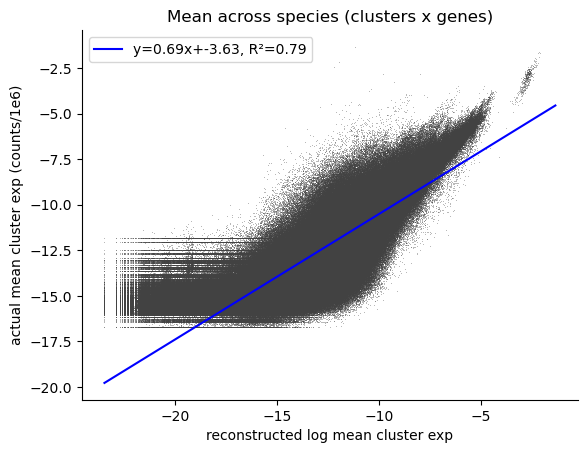

In [40]:
x=cluster_params.flatten()
y=log_real_means.mean(0).flatten()
mask = ~np.isnan(x) & ~np.isnan(y)
x=x[mask]
y=y[mask]
randinds=np.random.choice(np.array(list(range(len(y)))),size=200000,replace=False)

seaborn.scatterplot(x=x,y=y,s=0.2,color='black')
#seaborn.kdeplot(x=cluster_params.flatten()[randinds],y=log_real_means.mean(0).flatten()[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')

# Calculate the regression parameters
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(y), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean across species (clusters x genes)')
# Add legend
plt.legend()


In [ ]:
# x=(log_real_means-np.nanmean(log_real_means,0)).flatten()
# y=(safe_posterior_means-np.nanmean(safe_posterior_means,0)).flatten()
# mask = ~np.isnan(x) & ~np.isnan(y)# & (y >-19) & (x >-19)
# x=x[mask]
# y=y[mask]
# randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)

# seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
# seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
# plt.xlabel('true cluster ln FC')
# plt.ylabel('posterior mean cluster ln FC')

# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# # Plot the regression line
# x_values = np.linspace(np.min(x), np.max(x), 100)
# plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
# # Add legend
# plt.legend()

# filename = os.path.join(sc.settings.figdir, 'real_cluster_lfc_regression.png')
# plt.savefig(filename, format='png')
# plt.show()